In [36]:
# Run the notebook as if it's in the PROJECT directory
%bookmark PROJ_ROOT /reg/data/ana03/scratch/cwang31/pf
%cd -b PROJ_ROOT

(bookmark:PROJ_ROOT) -> /reg/data/ana03/scratch/cwang31/pf
/reg/data/ana03/scratch/cwang31/pf


In [37]:
!pwd

/reg/data/ana03/scratch/cwang31/pf


In [38]:
# Load paths for using psana
%env SIT_ROOT=/reg/g/psdm/
%env SIT_DATA=/cds/group/psdm/data/
%env SIT_PSDM_DATA=/cds/data/psdm/

env: SIT_ROOT=/reg/g/psdm/
env: SIT_DATA=/cds/group/psdm/data/
env: SIT_PSDM_DATA=/cds/data/psdm/


In [39]:
import numpy as np
import lmfit
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from peaknet.plugins      import PsanaImg, apply_mask
from peaknet.app_att_unet import PeakFinder
from peaknet.trans        import center_crop

import matplotlib.pyplot     as plt
import matplotlib.colors     as mcolors
import matplotlib.patches    as mpatches
import matplotlib.transforms as mtransforms
%matplotlib inline

### model

In [40]:
# # Read weights from a checkpoint file...
# timestamp  = "2023_0506_0308_15"   # 1920x1920
# epoch      = 101

# timestamp  = "2023_0728_2234_15"   # 1920x1920
# epoch      = 53

timestamp = "2023_0729_1047_58"
epoch     = 66

# timestamp = "2023_0726_2249_51"    # 480x480, Conv 3x3
# epoch     = 174

# timestamp = "2023_0726_2251_30"    # 480x480, Conv 1x1
# epoch     = 545

tag        = ".cpu"
fl_chkpt   = None if timestamp is None else f"{timestamp}.epoch_{epoch}{tag}.chkpt"
path_chkpt = os.path.join("chkpts", fl_chkpt)

path_cheetah_geom = None

# pf = PeakFinder(path_chkpt = path_chkpt, path_cheetah_geom = path_cheetah_geom)
pf = PeakFinder(path_chkpt = path_chkpt, path_cheetah_geom = path_cheetah_geom)
device = pf.device

### psana

In [41]:
exp           = 'mfx13016'
run           = 31
img_load_mode = 'calib'
access_mode   = 'idx'
detector_name = 'Rayonix'

psana_img = PsanaImg(exp, run, access_mode, detector_name)
mask_bad_pixel = psana_img.create_bad_pixel_mask()

WARNING - check_rayonix_geo: use rayonix segment geometry descriptor as MTRX:1920:1920:88.542:88.542


In [42]:
event = 3291

img = psana_img.get(event, None, 'calib')
img = apply_mask(img, mask_bad_pixel, mask_value = 0)

In [43]:
img_torch = torch.tensor(img).type(dtype=torch.float)[None,None,].to(device)
peaks, prediction_map = pf.find_peak_w_softmax(img_torch, min_num_peaks = 0, uses_geom = False, returns_prediction_map = True, uses_mixed_precision = True)

## Viz

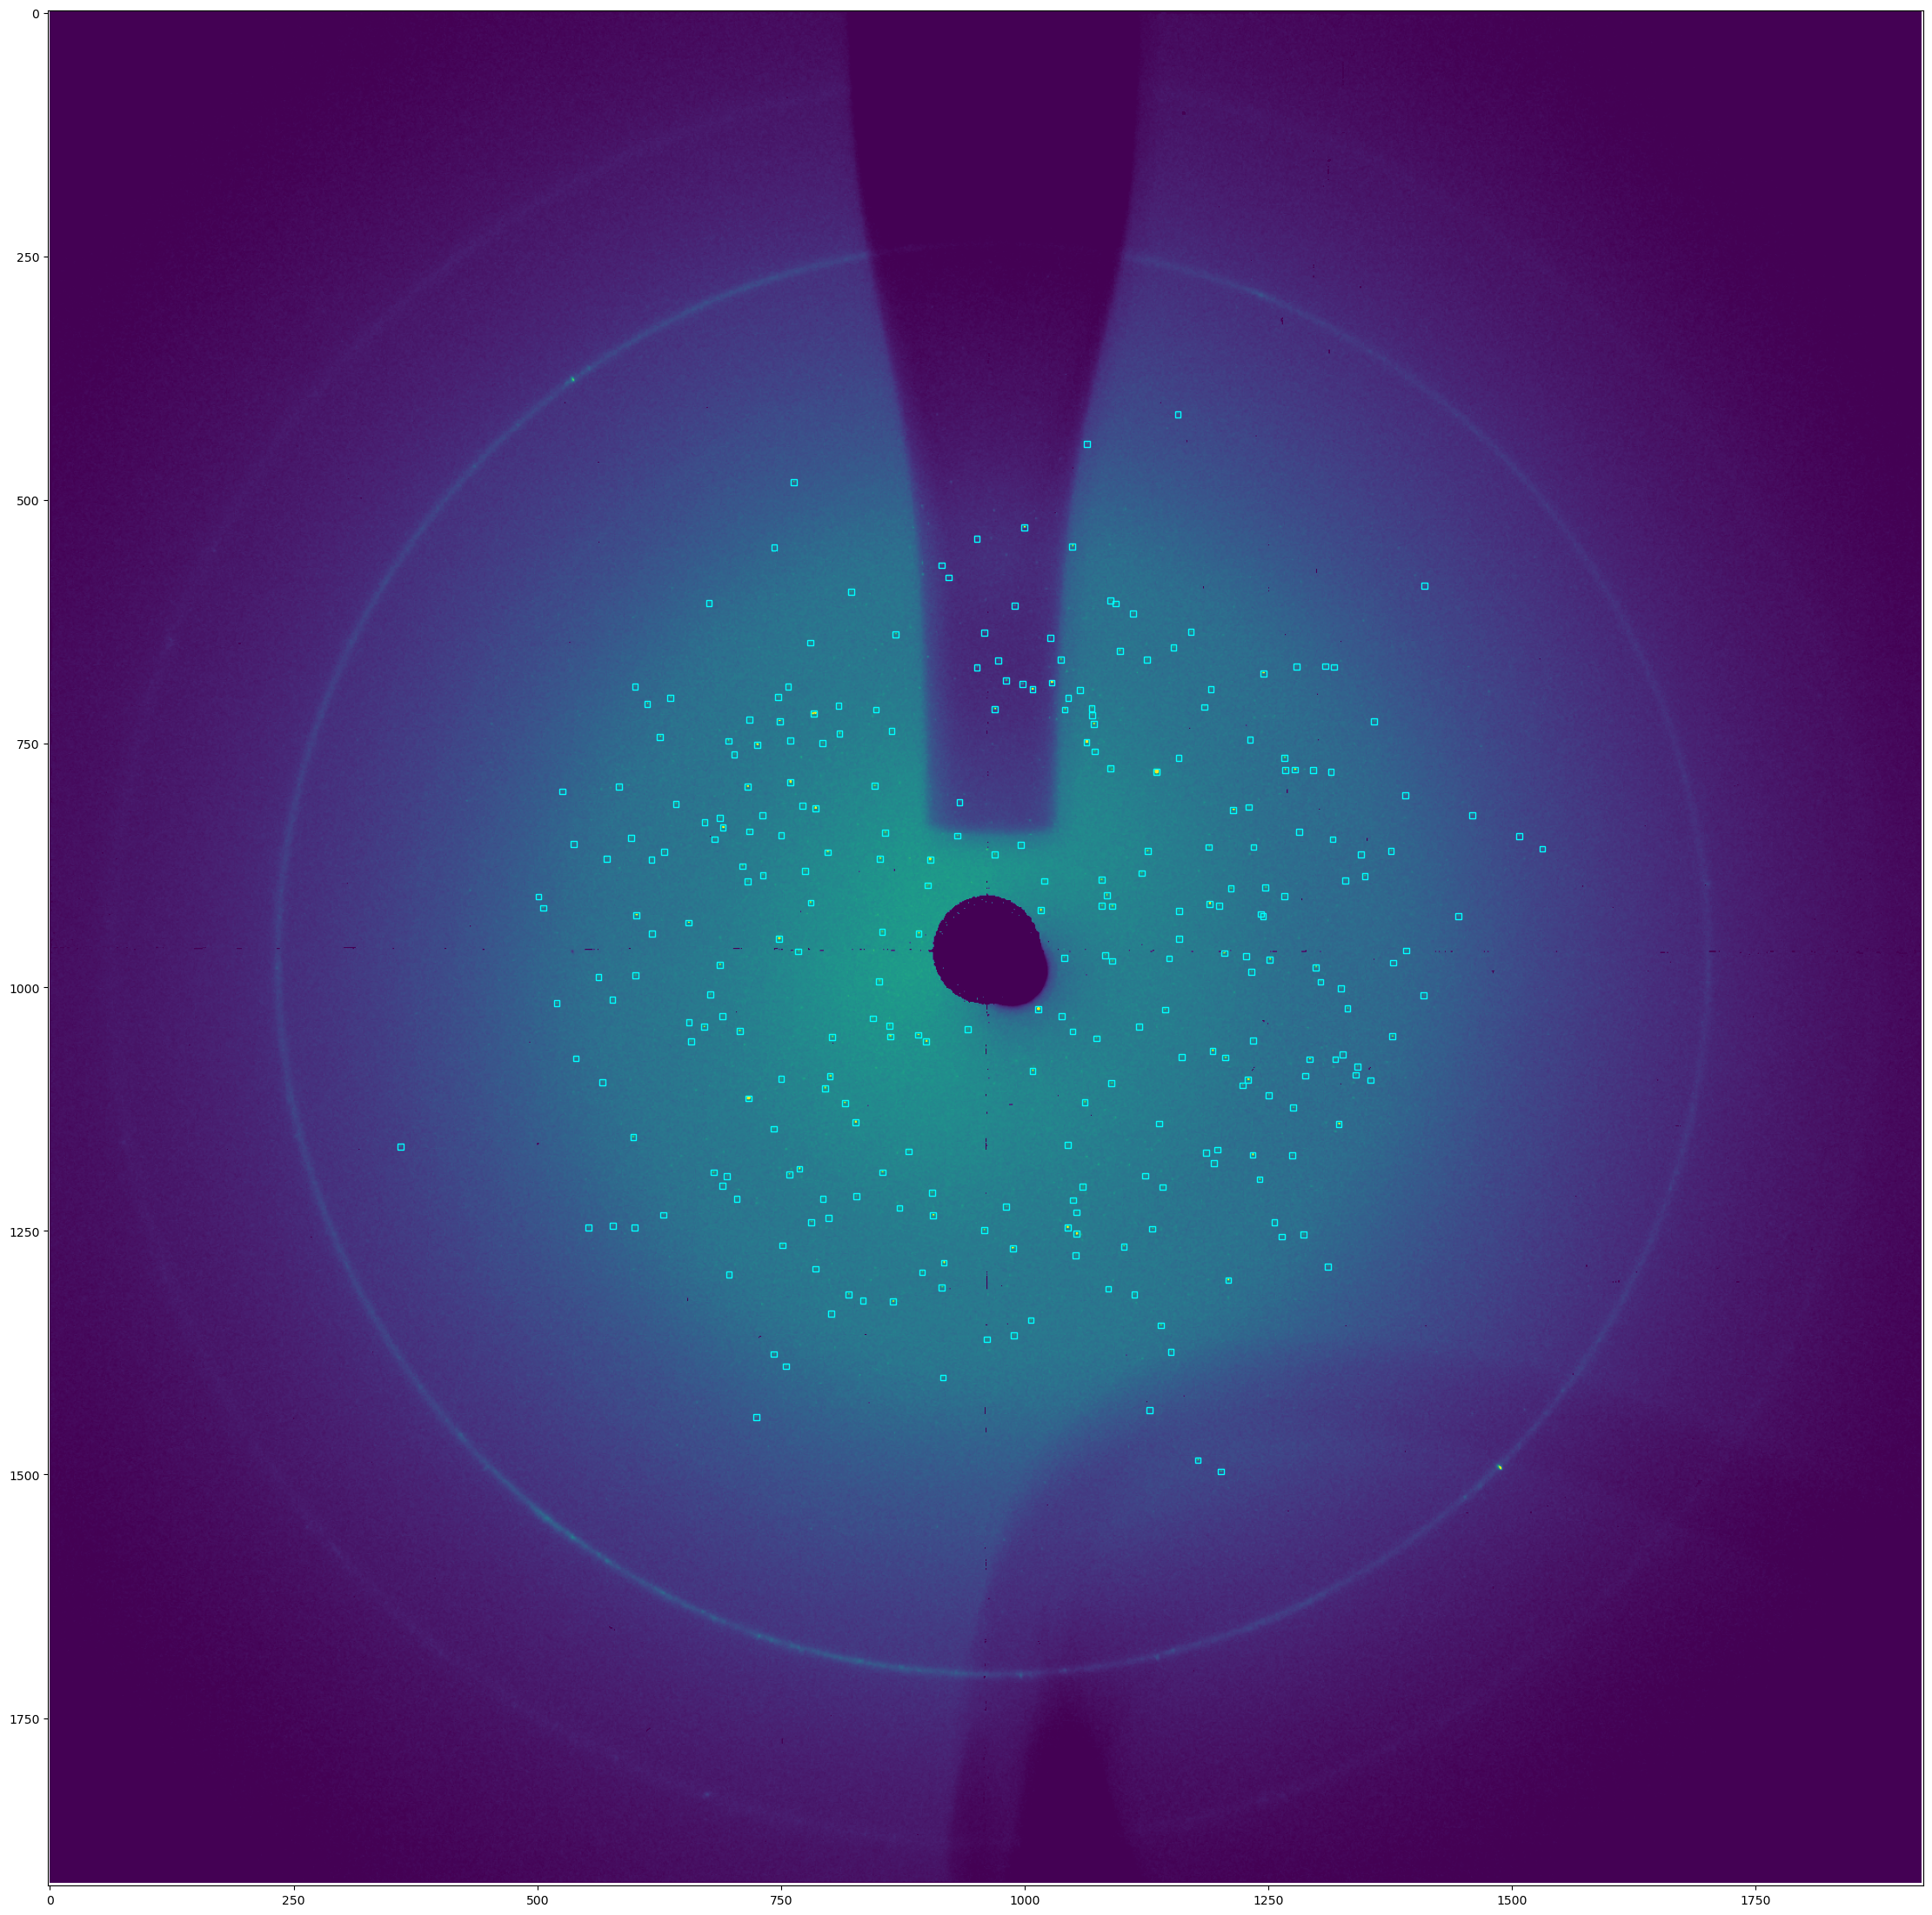

In [44]:
# [[[ Visual ]]]
# Set up the visual
scale = 2
ncols = 1
nrows = 1
fig   = plt.figure(figsize = (16*scale,14*scale))
gspec = fig.add_gridspec( nrows, ncols,
                          width_ratios  = [1],
                          height_ratios = [1,], 
                        )
ax_list = [ fig.add_subplot(gspec[0, 0], aspect = 1), ]

# Plot image
data = img
vmin = np.mean(data) - 1 * data.std()
vmax = np.mean(data) + 6 * data.std()
im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)
im.set_clim(vmin, vmax)

# Place a box on a peak
offset = 3
b_offset = 2
for _, y, x in peaks:
    if np.isnan(y) or np.isnan(x): continue

    x_bottom_left = x - offset
    y_bottom_left = y - offset

    rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left),
                                 2 * offset, 2 * offset, 
                                 linewidth = 1.0, 
                                 edgecolor = 'cyan', 
                                 facecolor='none')
    ax_list[0].add_patch(rec_obj)

size_y, size_x = img.shape[-2:]
y_bmin, x_bmin = 0, 0
y_bmax, x_bmax = size_y, size_x
ax_list[0].set_xlim([x_bmin - b_offset, x_bmax + b_offset])
ax_list[0].set_ylim([y_bmin - b_offset, y_bmax + b_offset])
ax_list[0].invert_yaxis()

In [45]:
img, vmin, vmax

(array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [ 0.      , 26.310001, 29.99    , ..., 26.560001, 29.55    ,
          0.      ],
        [ 0.      , 28.720001, 25.689999, ..., 21.43    , 21.4     ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]], dtype=float32),
 42.88486862182617,
 481.86492919921875)

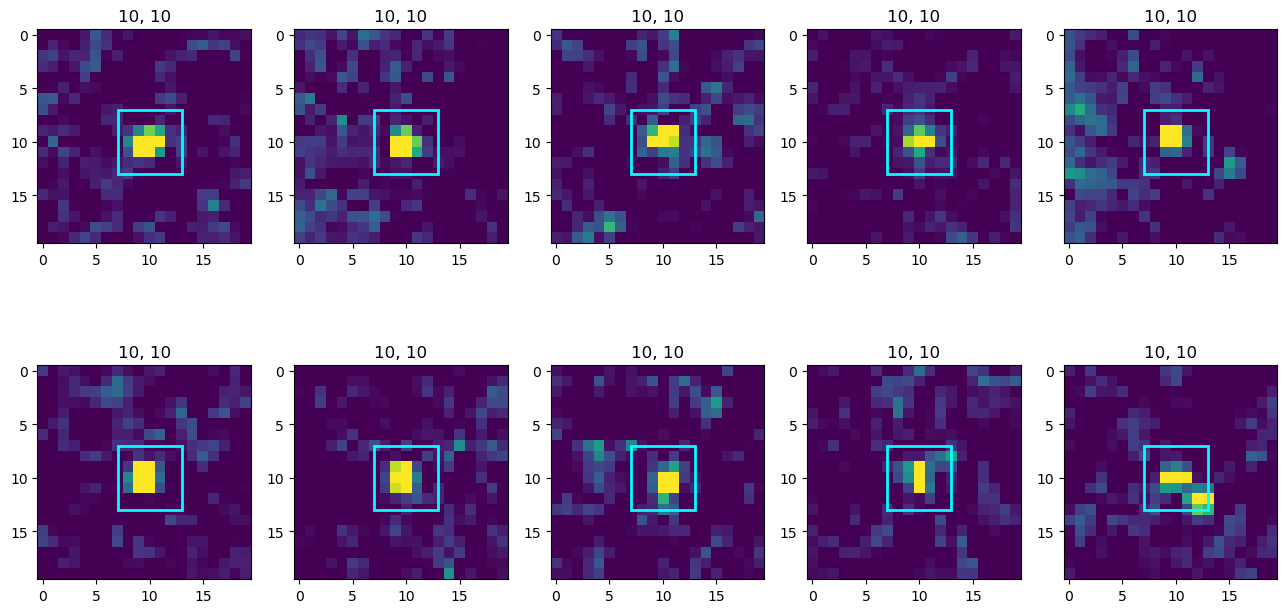

In [46]:
# [[[ Visual ]]]
# Set up the visual
scale = 2
ncols = 5
nrows = 2
fig   = plt.figure(figsize = (8*scale,4*scale))
gspec = fig.add_gridspec( nrows, ncols,
                          # width_ratios  = [1],
                          # height_ratios = [1,], 
                        )
ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

for row_idx in range(nrows):
    for col_idx in range(ncols):
        ax_idx = row_idx * ncols + col_idx
        ax = ax_list[ax_idx]

        peak_idx_list = random.choices(range(len(peaks)), k = 1)
        peak_idx = peak_idx_list[0]
        _, y, x = peaks[peak_idx]
        y, x = round(y), round(x)

        size_y, size_x = img.shape[-2:]

        win_size = 10
        x_min = max(x - win_size, 0)
        x_max = min(x + win_size, size_x)
        y_min = max(y - win_size, 0)
        y_max = min(y + win_size, size_y)

        # Plot image
        data = img[y_min:y_max, x_min:x_max]
        vmin = np.mean(data) - 0 * data.std()
        vmax = np.mean(data) + 4 * data.std()
        im = ax.imshow(data, vmin = vmin, vmax = vmax)
        # im = ax_list[0].imshow(data, vmin = 0, vmax = 1e5)
        # im.set_clim(vmin, vmax)

        # Place a box on a peak
        offset = 3
        b_offset = 2

        x_loc = x - x_min
        y_loc = y - y_min

        x_bottom_left = x_loc - offset
        y_bottom_left = y_loc - offset

        rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left),
                                     2 * offset, 2 * offset, 
                                     linewidth = 2.0, 
                                     edgecolor = 'cyan', 
                                     facecolor='none')
        ax.add_patch(rec_obj)

        ax.set_title(f"{x_loc}, {y_loc}")

# size_y, size_x = img.shape[-2:]
# y_bmin, x_bmin = y_min, x_min
# y_bmax, x_bmax = y_max, x_max
# ax_list[0].set_xlim([x_bmin - b_offset, x_bmax + b_offset])
# ax_list[0].set_ylim([y_bmin - b_offset, y_bmax + b_offset])
# ax_list[0].invert_yaxis()

## Fitting

In [47]:
import lmfit
# from lmfit        import Model
from lmfit.models import PseudoVoigtModel

### Model

In [48]:
class PseudoVoigt2D:
    def __init__(self, params):
        self.params = params

    
    def update_params(self, params):
        self.params.update(params)


    def _pseudo_voigt2D(self, y, x, amp, cy, cx, sigma_y, sigma_x, frac_y, frac_x):
        """
        y:
        x:
        """
        voigt_y = PseudoVoigtModel()
        voigt_x = PseudoVoigtModel()

        params_y = voigt_y.make_params(amplitude={"value" : amp}, 
                                       center   ={"value" : cy}, 
                                       sigma    ={"value" : sigma_y}, 
                                       fraction ={"value" : frac_y})
        params_x = voigt_x.make_params(amplitude={"value" : amp}, 
                                       center   ={"value" : cx}, 
                                       sigma    ={"value" : sigma_x}, 
                                       fraction ={"value" : frac_x})

        return voigt_y.eval(params_y, x=y) * voigt_x.eval(params_x, x=x)


    def _plane2d(self, y, x, a, b, c):
        return a * y + b * x + c


    def __call__(self, y, x):
        params  = self.params
    
        amp     = params["amp"]
        cy      = params["cy"]
        cx      = params["cx"]
        sigma_y = params["sigma_y"]
        sigma_x = params["sigma_x"]
        frac_y  = params["frac_y"]
        frac_x  = params["frac_x"]
        a       = params["a"]
        b       = params["b"]
        c       = params["c"]

        peak = self._pseudo_voigt2D(y, x, amp, cy, cx, sigma_y, sigma_x, frac_y, frac_x)
        bg   = self._plane2d(y, x, a, b, c)

        return peak + bg

In [119]:
class Residual:
    def __init__(self, params):
        self.params = lmfit.Parameters()
        for param, val in params.items():
            self.params.add(param, value = val)
    
        self.model = PseudoVoigt2D(params)
        # self.sample_step = sample_step

        return None
    
    
    def _residual(self, params, data, **kwargs):
        model = self.model
        # sample_step = self.sample_step

        H, W = data.shape[-2:]
        y = np.arange(0, H)
        x = np.arange(0, W)
        Y, X = np.meshgrid(y, x, indexing = 'ij')

        model.update_params(params)
        model_eval = model(Y, X)

        return model_eval - data

    
    def fit(self, data, **kwargs):
        res = lmfit.minimize(self._residual,
                             self.params,
                             method = 'leastsq',
                            #  method = 'least_squares',
                             max_nfev = 4000,
                             nan_policy = 'omit',
                             args = (data, ),
                             **kwargs)

        return res


### Example

In [50]:
peak_idx_list = random.choices(range(len(peaks)), k = 1)

peak_idx = peak_idx_list[0]
_, y, x = peaks[peak_idx]
y, x = round(y), round(x)

size_y, size_x = img.shape[-2:]

win_size = 10
x_min = max(x - win_size, 0)
x_max = min(x + win_size + 1, size_x)
y_min = max(y - win_size, 0)
y_max = min(y + win_size + 1, size_y)

# Plot image
data = img[y_min:y_max, x_min:x_max]

data = (data - data.mean()) / data.std()

amp = data.max() - data.min()
size_y, size_x = data.shape
bg = data.min()

In [51]:
params = {
    "amp" : amp,
    "cy"  : size_y//2,
    "cx"  : size_x//2,
    "sigma_y" : 2,
    "sigma_x" : 2,
    "frac_y"  : 0.5,
    "frac_x"  : 0.5,
    "a" : 0,
    "b" : 0,
    "c" : bg,
}


In [52]:
# lm_params = lmfit.Parameters()
# for param, val in params.items():
#     lm_params.add(param, value = val)

In [53]:
residual = Residual(params)
res = residual.fit(data)

In [54]:
res

In [55]:
pseudo_voigt2d = PseudoVoigt2D(res.params)

In [56]:
H, W = data.shape[-2:]
y = np.arange(0, H)
x = np.arange(0, W)
Y, X = np.meshgrid(y, x, indexing = 'ij')
model_val = pseudo_voigt2d(Y, X)

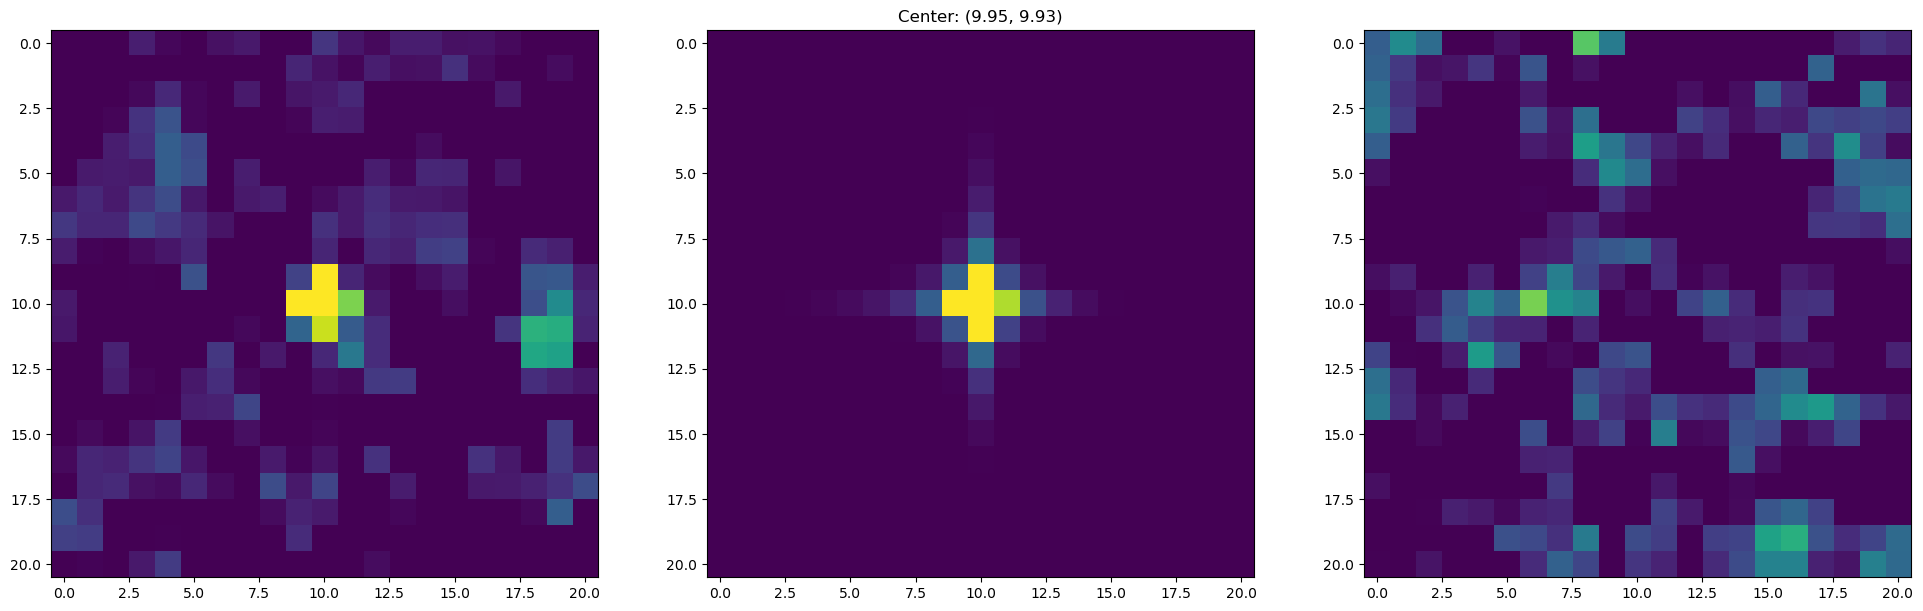

In [57]:
# [[[ Visual ]]]
# Set up the visual
scale = 2
ncols = 3
nrows = 1
fig   = plt.figure(figsize = (12*scale,4*scale))
gspec = fig.add_gridspec( nrows, ncols,
                        #   width_ratios  = [1],
                        #   height_ratios = [1,], 
                        )
ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols) ]

ax = ax_list[0]
vmin = np.mean(data) - 0 * data.std()
vmax = np.mean(data) + 4 * data.std()
im = ax.imshow(data, vmin = vmin, vmax = vmax)

ax = ax_list[1]
vmin = np.mean(model_val) - 0 * model_val.std()
vmax = np.mean(model_val) + 4 * model_val.std()
im = ax.imshow(model_val, vmin = vmin, vmax = vmax)

# frac_y = res.params["frac_y"].value
# sigma_y = res.params["sigma_y"].value
# frac_x = res.params["frac_x"].value
# sigma_x = res.params["sigma_x"].value
# fg_y = 2 * sigma_y * np.sqrt(2 * np.log(2))
# fl_y = 2 * frac_y
# fwhm_y = 0.5346 * fl_y + np.sqrt(0.2166 * fl_y * fl_y + fg_y * fg_y)
# fg_x = 2 * sigma_x * np.sqrt(2 * np.log(2))
# fl_x = 2 * frac_x
# fwhm_x = 0.5346 * fl_x + np.sqrt(0.2166 * fl_x * fl_x + fg_x * fg_x)
# ax.set_title(f'Model, FWHM = ({fwhm_y:.1f}, {fwhm_x:.1f})')

cy = res.params["cy"].value
cx = res.params["cx"].value
ax.set_title(f'Center: ({cy:.2f}, {cx:.2f})')

residual_val = model_val - data
ax = ax_list[2]
vmin = np.mean(residual_val) - 0 * residual_val.std()
vmax = np.mean(residual_val) + 4 * residual_val.std()
im = ax.imshow(residual_val, vmin = vmin, vmax = vmax)

In [58]:
cx, cy

(9.927627597657256, 9.95332773383278)

In [59]:
res.params

Parameters([('amp', <Parameter 'amp', value=6.871558736458912, bounds=[-inf:inf]>), ('cy', <Parameter 'cy', value=9.95332773383278, bounds=[-inf:inf]>), ('cx', <Parameter 'cx', value=9.927627597657256, bounds=[-inf:inf]>), ('sigma_y', <Parameter 'sigma_y', value=0.6037034679829218, bounds=[-inf:inf]>), ('sigma_x', <Parameter 'sigma_x', value=0.5260962441564666, bounds=[-inf:inf]>), ('frac_y', <Parameter 'frac_y', value=1.0070554362493944, bounds=[-inf:inf]>), ('frac_x', <Parameter 'frac_x', value=1.2383321808716499, bounds=[-inf:inf]>), ('a', <Parameter 'a', value=-0.00252034398145752, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=-0.006065040848373935, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=-0.025869162585187903, bounds=[-inf:inf]>)])

In [60]:
np.sqrt((res.residual**2).mean())

0.6133092883051977

### Example (Batch)

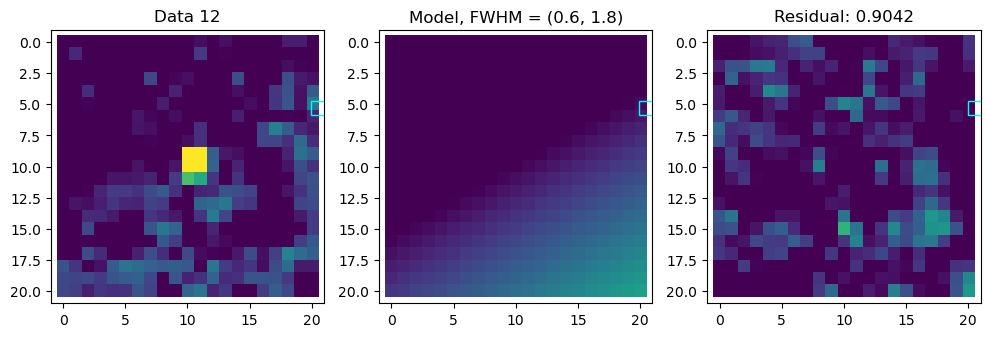

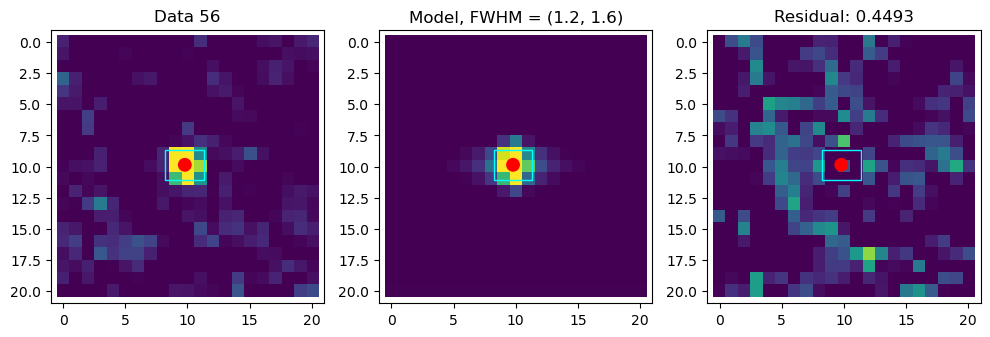

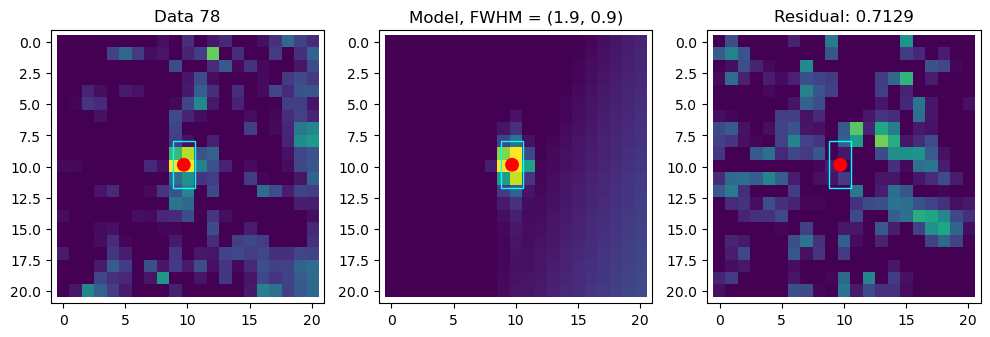

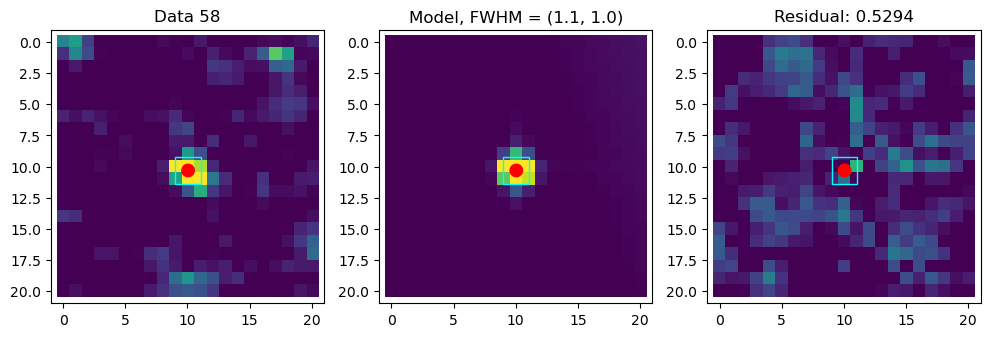

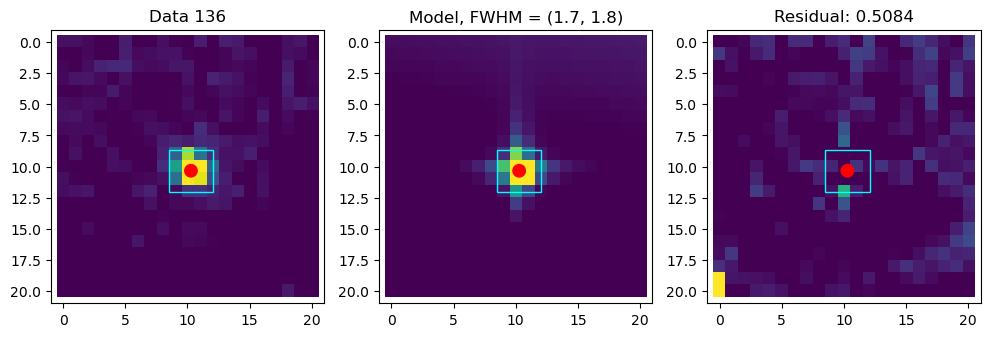

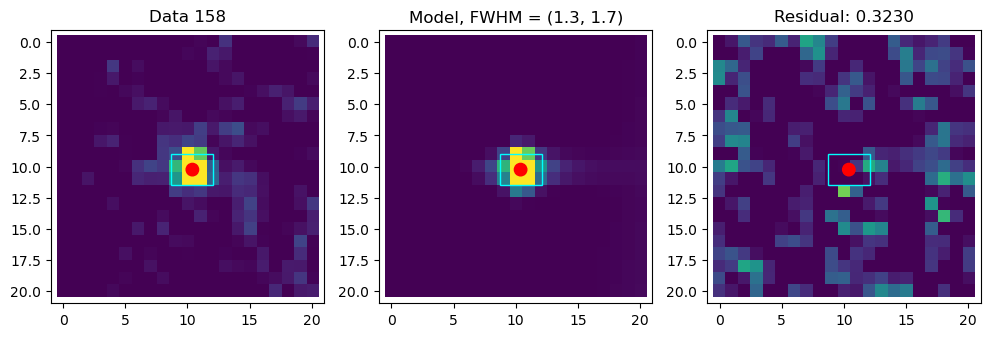

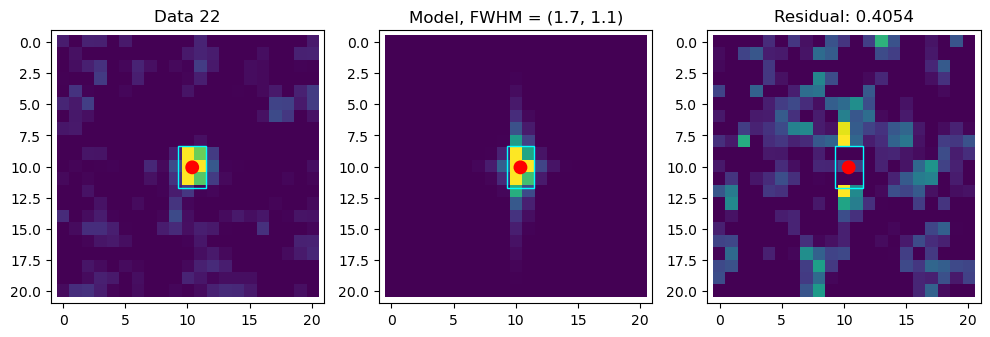

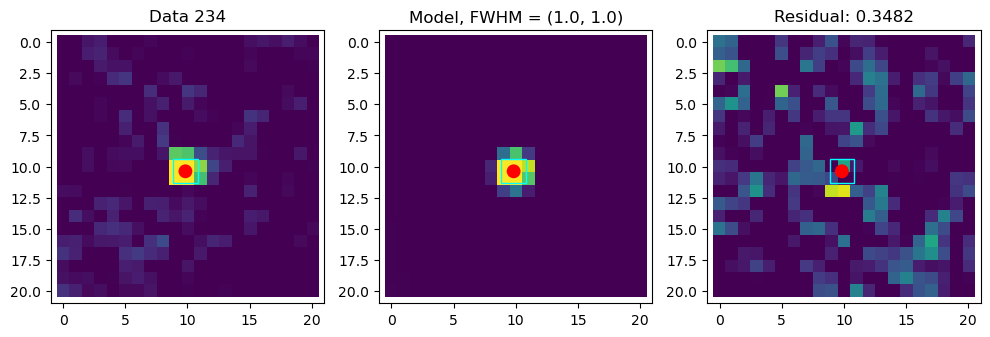

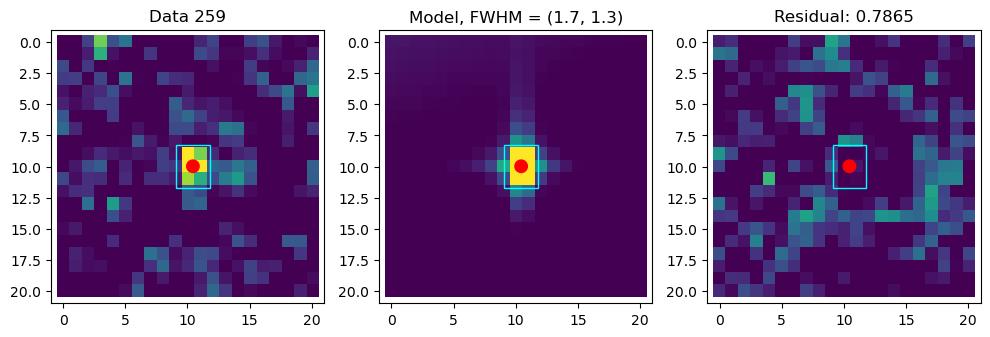

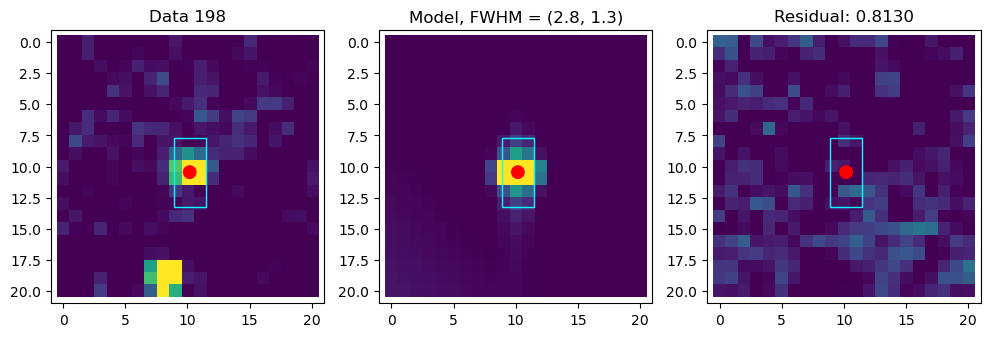

In [121]:
for _ in range(10):
    peak_idx_list = random.choices(range(len(peaks)), k = 1)

    peak_idx = peak_idx_list[0]
    _, y, x = peaks[peak_idx]
    y, x = round(y), round(x)

    size_y, size_x = img.shape[-2:]

    win_size = 10
    x_min = max(x - win_size, 0)
    x_max = min(x + win_size + 1, size_x)
    y_min = max(y - win_size, 0)
    y_max = min(y + win_size + 1, size_y)

    # Plot image
    data = img[y_min:y_max, x_min:x_max]

    data = (data - data.mean()) / data.std()

    bg  = 0
    amp = data.max()
    size_y, size_x = data.shape
    params = {
        "amp" : amp,
        "cy"  : size_y//2,
        "cx"  : size_x//2,
        "sigma_y" : 2,
        "sigma_x" : 2,
        "frac_y"  : 0.5,
        "frac_x"  : 0.5,
        "a" : 0,
        "b" : 0,
        "c" : bg,
    }

    residual = Residual(params)
    res = residual.fit(data)

    pseudo_voigt2d = PseudoVoigt2D(res.params)

    H, W = data.shape[-2:]
    y = np.arange(0, H)
    x = np.arange(0, W)
    Y, X = np.meshgrid(y, x, indexing = 'ij')
    model_val = pseudo_voigt2d(Y, X)

    # [[[ Visual ]]]
    # Set up the visual
    scale = 1
    ncols = 3
    nrows = 1
    fig   = plt.figure(figsize = (12*scale,4*scale))
    gspec = fig.add_gridspec( nrows, ncols,
                            #   width_ratios  = [1],
                            #   height_ratios = [1,], 
                            )
    ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols) ]

    ax = ax_list[0]
    vmin = np.mean(data) - 0 * data.std()
    vmax = np.mean(data) + 4 * data.std()
    im = ax.imshow(data, vmin = vmin, vmax = vmax)
    ax.set_title(f'Data {peak_idx:d}')

    ax = ax_list[1]
    vmin = np.mean(model_val) - 0 * model_val.std()
    vmax = np.mean(model_val) + 4 * model_val.std()
    im = ax.imshow(model_val, vmin = vmin, vmax = vmax)

    frac_y  = res.params["frac_y" ].value
    sigma_y = res.params["sigma_y"].value
    frac_x  = res.params["frac_x" ].value
    sigma_x = res.params["sigma_x"].value
    fg_y    = 2 * sigma_y * np.sqrt(2 * np.log(2))
    fl_y    = 2 * frac_y
    fwhm_y  = 0.5346 * fl_y + np.sqrt(0.2166 * fl_y * fl_y + fg_y * fg_y)
    fg_x    = 2 * sigma_x * np.sqrt(2 * np.log(2))
    fl_x    = 2 * frac_x
    fwhm_x  = 0.5346 * fl_x + np.sqrt(0.2166 * fl_x * fl_x + fg_x * fg_x)
    ax.set_title(f'Model, FWHM = ({fwhm_y/2:.1f}, {fwhm_x/2:.1f})')

    # cy = res.params["cy"].value
    # cx = res.params["cx"].value
    # ax.set_title(f'Center: ({cy:.2f}, {cx:.2f})')

    residual_val = model_val - data
    ax = ax_list[2]
    vmin = np.mean(residual_val) - 0 * residual_val.std()
    vmax = np.mean(residual_val) + 4 * residual_val.std()
    im = ax.imshow(residual_val, vmin = vmin, vmax = vmax)

    rms = np.sqrt((residual_val**2).mean())
    ax.set_title(f'Residual: {rms:.4f}')


    # Place a box on a peak   
    cy = res.params["cy"].value
    cx = res.params["cx"].value
    x_bottom_left = cx - fwhm_x/2
    y_bottom_left = cy - fwhm_y/2

    for ax_idx in range(len(ax_list)):
        rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left),
                                    fwhm_x, fwhm_y, 
                                    linewidth = 1.0, 
                                    edgecolor = 'cyan', 
                                    facecolor='none')
        cir_obj = mpatches.Circle((cx, cy),
                                        radius = 0.5,
                                        linewidth = 1.0, 
                                        edgecolor = 'red', 
                                        facecolor='red')
        ax = ax_list[ax_idx]
        ax.add_patch(rec_obj)
        ax.add_patch(cir_obj)

        ax.set_xlim([0-1, 21])
        ax.set_ylim([0-1, 21])
        ax.invert_yaxis()

In [62]:
data.shape

(21, 21)

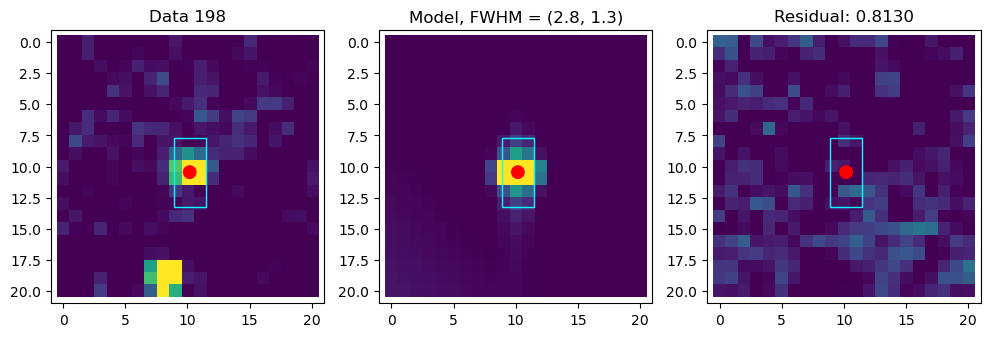

In [122]:
peak_idx_list = [
                #   168, 
                  # 0,
                  # 15,
                  # 101,
                  198,
                ]

peak_idx = peak_idx_list[0]
_, y, x = peaks[peak_idx]
y, x = round(y), round(x)

size_y, size_x = img.shape[-2:]

win_size = 10
x_min = max(x - win_size, 0)
x_max = min(x + win_size + 1, size_x)
y_min = max(y - win_size, 0)
y_max = min(y + win_size + 1, size_y)

# Plot image
data = img[y_min:y_max, x_min:x_max]

data = (data - data.mean()) / data.std()

bg = 0
amp = data.max()
size_y, size_x = data.shape

params = {
    "amp" : amp,
    "cy"  : size_y//2,
    "cx"  : size_x//2,
    "sigma_y" : 2,
    "sigma_x" : 2,
    "frac_y"  : 0.5,
    "frac_x"  : 0.5,
    "a" : 0,
    "b" : 0,
    "c" : bg,
}

residual = Residual(params)
res = residual.fit(data)

pseudo_voigt2d = PseudoVoigt2D(res.params)

H, W = data.shape[-2:]
y = np.arange(0, H)
x = np.arange(0, W)
Y, X = np.meshgrid(y, x, indexing = 'ij')
model_val = pseudo_voigt2d(Y, X)

# [[[ Visual ]]]
# Set up the visual
scale = 1
ncols = 3
nrows = 1
fig   = plt.figure(figsize = (12*scale,4*scale))
gspec = fig.add_gridspec( nrows, ncols,
                        #   width_ratios  = [1],
                        #   height_ratios = [1,], 
                        )
ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols) ]

ax = ax_list[0]
vmin = np.mean(data) - 0 * data.std()
vmax = np.mean(data) + 4 * data.std()
im = ax.imshow(data, vmin = vmin, vmax = vmax)
ax.set_title(f'Data {peak_idx:d}')

ax = ax_list[1]
vmin = np.mean(model_val) - 0 * model_val.std()
vmax = np.mean(model_val) + 4 * model_val.std()
im = ax.imshow(model_val, vmin = vmin, vmax = vmax)

frac_y  = res.params["frac_y" ].value
sigma_y = res.params["sigma_y"].value
frac_x  = res.params["frac_x" ].value
sigma_x = res.params["sigma_x"].value
fg_y    = 2 * sigma_y * np.sqrt(2 * np.log(2))
fl_y    = 2 * frac_y
fwhm_y  = 0.5346 * fl_y + np.sqrt(0.2166 * fl_y * fl_y + fg_y * fg_y)
fg_x    = 2 * sigma_x * np.sqrt(2 * np.log(2))
fl_x    = 2 * frac_x
fwhm_x  = 0.5346 * fl_x + np.sqrt(0.2166 * fl_x * fl_x + fg_x * fg_x)
ax.set_title(f'Model, FWHM = ({fwhm_y/2:.1f}, {fwhm_x/2:.1f})')

# cy = res.params["cy"].value
# cx = res.params["cx"].value
# ax.set_title(f'Center: ({cy:.2f}, {cx:.2f})')

residual_val = model_val - data
ax = ax_list[2]
vmin = np.mean(residual_val) - 0 * residual_val.std()
vmax = np.mean(residual_val) + 4 * residual_val.std()
im = ax.imshow(residual_val, vmin = vmin, vmax = vmax)

rms = np.sqrt((residual_val**2).mean())
ax.set_title(f'Residual: {rms:.4f}')


# Place a box on a peak   
cy = res.params["cy"].value
cx = res.params["cx"].value
x_bottom_left = cx - fwhm_x/2
y_bottom_left = cy - fwhm_y/2

for ax_idx in range(len(ax_list)):
    rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left),
                                fwhm_x, fwhm_y, 
                                linewidth = 1.0, 
                                edgecolor = 'cyan', 
                                facecolor='none')
    cir_obj = mpatches.Circle((cx, cy),
                                    radius = 0.5,
                                    linewidth = 1.0, 
                                    edgecolor = 'red', 
                                    facecolor='red')
    ax = ax_list[ax_idx]
    ax.add_patch(rec_obj)
    ax.add_patch(cir_obj)

    ax.set_xlim([0-1, 21])
    ax.set_ylim([0-1, 21])
    ax.invert_yaxis()

In [123]:
res

In [125]:
np.sqrt((res.residual**2).mean())

0.8130157437692968